In [1]:
%run ../utils_rf
from sklearn import tree

In [2]:
def get_paths(tree):
    
    children_left = tree.children_left
    children_right = tree.children_right
    values = tree.value
    
    paths = []
    is_inc = []
    path = []
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()    
               
        while len(path)>parent_depth+1:
            path.pop()
        path.append(node_id)
        
        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            paths.append(path.copy())
            is_inc.append(values[node_id][0][0]>values[node_id][0][1])

    return paths, is_inc

In [3]:
def increase_contributors(model):    
    path_thresholds = []
    path_features = []
    is_inc_full = []

    for treeEst in model.estimators_:
        children_left = treeEst.tree_.children_left
        children_right = treeEst.tree_.children_right
        all_thresholds = treeEst.tree_.threshold
        all_features = treeEst.tree_.feature

        paths, is_inc = get_paths(treeEst.tree_)
        is_inc_full.append(is_inc.copy())

        for i in range(len(paths)):
            thresholds = []
            features = []
            for j in range(len(paths[i])-1):
                if paths[i][j+1] == children_right[paths[i][j]]:
                    thresholds.append(all_thresholds[paths[i][j]])
                else:
                    thresholds.append(-all_thresholds[paths[i][j]])
                features.append(all_features[paths[i][j]])
            path_thresholds.append(thresholds.copy())
            path_features.append(features.copy())
    
    return np.asarray(path_features), np.asarray(path_thresholds), np.hstack(is_inc_full)

In [4]:
def conditional_contribution(ordered_features,ip_features,ip_thresholds):
    
    feature_thresholds = []
    
    i=0
    for path in ip_features:
        if  np.all(np.isin(ordered_features,path)):
            feature_loc = []
            for feature in ordered_features:
                feature_loc.append(path.index(feature))
            if np.all(feature_loc[:-1] <= feature_loc[1:]):
                thresholds = []
                for feature in ordered_features:
                    thresholds.append(ip_thresholds[i][path.index(feature)])
                feature_thresholds.append(thresholds.copy())
        i=i+1
    
    return np.asarray(feature_thresholds)

In [5]:
def get_scores(check_list,ip_features,ip_thresholds):
    thresholds = conditional_contribution(check_list,ip_features,ip_thresholds)
    if thresholds.size!=0:
        counts = np.unique(thresholds/abs(thresholds),axis=0,return_counts=True)
        score = np.max(counts[1]/sum(counts[1]))
        direction = counts[0][np.argmax(counts[1])]
    else:
        score=0
        direction=None
    temp = {'feature': check_list[-1],
            'conditional': check_list[:-1],
            'score': score,
            'direction': direction,
            'count':len(thresholds)}
    return temp

In [6]:
def get_influence_directions(cutoff,features,rf_model):

    path_features, path_thresholds, is_inc = increase_contributors(rf_model)
    ip_features = path_features[is_inc].copy()
    ip_thresholds = path_thresholds[is_inc].copy()
       
    ip_thresholds_flat = np.asarray([item for sublist in ip_thresholds for item in sublist])
    ip_features_flat = np.asarray([item for sublist in ip_features for item in sublist])
        
    feature_directions = []
    for feature in features:
        GT_count = len(ip_thresholds_flat[np.logical_and(ip_features_flat==feature,ip_thresholds_flat>0)]) 
        LT_count = len(ip_thresholds_flat[np.logical_and(ip_features_flat==feature,ip_thresholds_flat<0)])
        if GT_count + LT_count != 0:
            score = max(GT_count,LT_count)/(GT_count + LT_count)
        else:
            score = 0
        if abs(score)>cutoff:
            feature_directions.append({'feature':feature,
                                       'score':abs(score),
                                       'direction': (1 if GT_count>LT_count else -1),
                                       'count':(GT_count + LT_count)})
            features = np.delete(features,np.where(features==feature))

    if features.size!=0:
        for feature in features:
            for i in range(rf_model.n_features_):
                if i!=feature:
                    temp = get_scores([i,feature],ip_features,ip_thresholds)
                    if temp['score']>cutoff:
                        feature_directions.append(temp.copy())
                        features = np.delete(features,np.where(features==feature))

    if features.size!=0:
        for feature in features:
            for i in range(rf_model.n_features_):
                for j in range(rf_model.n_features_):
                    if i!=feature and j!=feature:
                        temp = get_scores([i,j,feature],ip_features,ip_thresholds)
                        if temp['score']>cutoff:
                            feature_directions.append(temp.copy())
                            features = np.delete(features,np.where(features==feature))
    return feature_directions, features

In [7]:
def get_is_increase_portions(feature_pairs,rf_model):
    
    path_features, path_thresholds, is_inc = increase_contributors(rf_model)
    is_inc_portions = []
    
    for feature in feature_pairs.index:
        conditional = abs(feature_pairs.loc[feature,'conditional'])
        cond_direction = feature_pairs.loc[feature,'conditional']/conditional
        right_path = []
        left_path = []
        i=0
        for path in path_features:
            if feature in path and conditional in path:
                correct_order = path.index(feature) >=  path.index(conditional)
                if conditional!=feature: 
                    correct_direction = path_thresholds[i][path.index(conditional)]/cond_direction>0 
                else:
                    correct_direction=True
                right = path_thresholds[i][path.index(feature)] > 0
                left = path_thresholds[i][path.index(feature)] < 0
                right_path.append(correct_order and correct_direction and right)
                left_path.append(correct_order and correct_direction and left)
            else:
                right_path.append(False)
                left_path.append(False)
            i=i+1
        is_inc_portions.append({
            'conditional': x.columns[conditional],
            'cond direction': cond_direction,
            'feature': x.columns[feature],
            'inc portion of right paths': sum(np.logical_and(is_inc,right_path))/sum(right_path),
            'right path count': sum(right_path),
            'inc portion of left paths': sum(np.logical_and(is_inc,left_path))/sum(left_path),
            'left path count': sum(left_path)
        })
    
    return is_inc_portions

In [8]:
#read training data
file = "../../tables/model_input/noc_answers.csv"
x, x_agg, y, y_agg, x_noclvl, y_noclvl = data_proccess(file,True)
x.drop(['work_num_1','work_num_2','work_num_3','work_num_4','work_num_5','work_num_6'],axis=1,inplace=True)

#grab just the noc codes to cut out test nocs from main noc table
train_nocs = pd.read_csv(file,usecols=['noc_code']).drop_duplicates()

In [9]:
f = open('../../tables/SFFS_output/inc_features.txt', 'r')
sffs_prob_features = f.readlines()
f.close()

sffs_prob_features = [x[:-1] for x in sffs_prob_features]

In [7]:
rf = RandomForestClassifier(**init_params('cat'))

rf.fit(x,y['increase'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Feature Importances

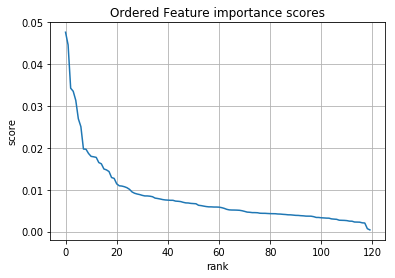

In [9]:
rf_features = pd.Series(rf.feature_importances_,index=x.columns)
plt.plot(range(120),rf_features.sort_values(ascending=False))
plt.title('Ordered Feature importance scores')
plt.ylabel('score')
plt.xlabel('rank')
plt.grid()
plt.savefig('feature importance.png')
plt.show()

In [12]:
np.savetxt("feature_importances_nonsffs.csv", rf.feature_importances_, delimiter=",")

In [8]:
selected_features = rf_features.sort_values(ascending=False).iloc[0:20]
selected_features

NameError: name 'rf_features' is not defined

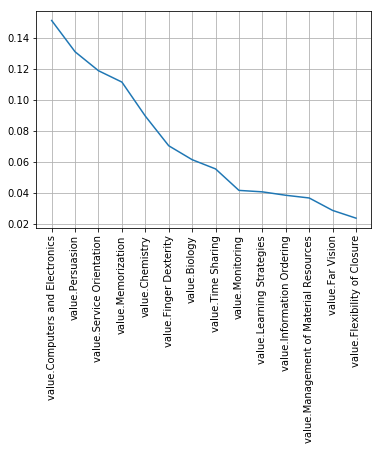

In [14]:
sffs_features = pd.Series(rf_sffs.feature_importances_,index=x_sffs.columns).sort_values(ascending=False)
plt.plot(sffs_features)
plt.xticks(rotation=90)
plt.grid()
plt.show()

Next lets draw a tree

In [15]:
decTree = rf.estimators_[0]

dotfile = open("dtree.dot", 'w')
tree.export_graphviz(decTree, out_file=dotfile, 
                      feature_names=x.columns,  
                      class_names=['increase','not_increase'],  
                      filled=True, rounded=True,  
                      special_characters=True)
dotfile.close()

OK Lets put it all together

In [16]:
selected_features_ix = np.where(np.isin(x.columns,selected_features.index))[0]
feature_directions, features = get_influence_directions(0.85,selected_features_ix,rf)

In [17]:
feature_dir_table = pd.DataFrame(feature_directions,columns=['feature','conditional','direction','score','count'])
feature_dir_table['feature'] = x.columns[feature_dir_table['feature']].copy()
feature_dir_table.loc[3:,'conditional'] = x.columns[np.hstack(feature_dir_table.loc[3:,'conditional'])].copy()
feature_dir_table['direction'] = feature_dir_table['direction'].astype(str)
feature_dir_table = feature_dir_table[feature_dir_table['count']>10].copy()

In [40]:
feature_dir_table.sort_values('count',ascending=False).loc[feature_dir_table['feature']==12]

,feature,conditional,direction,score,count
5,12,[14],"[1.0, 1.0]",1.000000,23
21,12,[66],"[-1.0, 1.0]",1.000000,18
17,12,[59],"[-1.0, 1.0]",0.857143,14
33,12,[116],"[-1.0, -1.0]",0.923077,13
23,12,[84],"[-1.0, -1.0]",0.916667,12
24,12,[87],"[-1.0, -1.0]",1.000000,11


In [21]:
feature_dir_table.sort_values('count',ascending=False).loc

,feature,conditional,direction,score,count
0,39,NaN,1,0.868106,417
1,40,NaN,1,0.860795,352
2,116,NaN,-1,0.878788,330
215,53,[40],"[1.0, 1.0]",0.938776,49
214,53,[39],"[1.0, 1.0]",0.897959,49
266,66,[14],"[1.0, -1.0]",0.869565,46
205,53,[14],"[1.0, 1.0]",0.878788,33
5,12,[14],"[1.0, 1.0]",1.000000,23
234,53,[116],"[-1.0, 1.0]",0.857143,21
208,53,[21],"[-1.0, 1.0]",0.857143,21


In [27]:
feature_dir_table = pd.DataFrame(feature_directions,columns=['feature','conditional','direction','score','count'])
feature_dir_table = feature_dir_table[feature_dir_table['count']>10].copy()
feature_combos = []
for index, row in feature_dir_table.iterrows():
    feature_combos.append([row['conditional'],row['feature']])
    